## Introduction and set up

If you've finished going through my [Linear model and neural net from scratch
](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch) notebook, then now is a good time to look at how to do the same thing using a library, instead of doing it from scratch. We'll use fastai and PyTorch. The benefits of using these libraries is:

- Best practices are handled for you automatically -- fast.ai has done thousands of hours of experiments to figure out what the best settings are for you
- Less time getting set up, which means more time to try out your new ideas
- Each idea you try will be less work, because fastai and PyTorch will do the many of the menial bits for you
- You can always drop down from fastai to PyTorch if you need to customise any part (or drop down from the fastai Application API to the fastai mid or low tier APIs), or even drop down from PyTorch to plain python for deep customisation.

Let's see how that looks in practice. We'll start by doing the same library setup as in the "from scratch" notebook:

In [ ]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = path = Path.home()/'titanic'
    if not path.exists():
        import zipfile, kaggle
        kaggle.api.competition_download_cli(path.name, path=path)
        zipfile.ZipFile(f'{path}/{path.name}.zip').extractall(path)

We'll import the fastai tabular library, set a random seed so the notebook is reproducible, and pick a reasonable number of significant figures to display in our tables:

In [ ]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## Prep the data

We'll read the CSV file just like we did before:

In [ ]:
df = pd.read_csv(path/'train.csv')

When you do everything from scratch, every bit of feature engineering requires a whole lot of work, since you have to think about things like dummy variables, normalization, missing values, and so on. But with fastai that's all done for you. So let's go wild and create lots of new features! We'll use a bunch of the most interesting ones from this fantastic [Titanic feature engineering notebook](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/) (and be sure to click that link and upvote that notebook if you like it to thank the author for their hard work!)

In [ ]:
df.Cabin.str[0]

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: Cabin, Length: 891, dtype: object

In [ ]:
(df.SibSp + df.Parch + 1).value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
dtype: int64

In [ ]:
df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [ ]:
# this counts the number of people in the dataset which have the same ticket as each row
df.groupby('Ticket')['Ticket'].transform('count')

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: Ticket, Length: 891, dtype: int64

In [ ]:
df[df['Ticket'] == '113803']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
137,138,0,1,"Futrelle, Mr. Jacques Heath",male,37.00,1,0,113803,53.10,C123,S


In [ ]:
df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: 0, Length: 891, dtype: object

In [ ]:
df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0].map(dict(Mr="Mr", Miss="Miss", Mrs="Mrs", Master="Master")).value_counts(dropna=False)

Mr        517
Miss      182
Mrs       125
Master     40
NaN        27
Name: 0, dtype: int64

In [ ]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp + df.Parch + 1
    df['Alone'] = df.Family == 1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr", Miss="Miss", Mrs="Mrs", Master="Master"))

add_features(df)

In [ ]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,2,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,2,False,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,1,True,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,2,False,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,1,True,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.00,NaN,S,2.64,NaN,1,True,1,NaN
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.00,B42,S,3.43,ABC,1,True,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,3.20,NaN,4,False,2,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C,3.43,ABC,1,True,1,Mr


As we discussed in the last notebook, we can use `RandomSplitter` to separate out the training and validation sets:

In [ ]:
splits = RandomSplitter(seed=42)(df)

Now the entire process of getting the data ready for training requires just this one cell!:

In [ ]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names = ['Sex', 'Pclass', 'Embarked', 'Deck', 'Title'],
    cont_names= ['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names='Survived', y_block= CategoryBlock(),
).dataloaders()

Here's what each of the parameters means:

- Use `splits` for indices of training and validation sets:

      splits=splits,
    
- Turn strings into categories, fill missing values in numeric columns with the median, normalise all numeric columns:
    
      procs = [Categorify, FillMissing, Normalize],
    
- These are the categorical independent variables:
    
      cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    
- These are the continuous independent variables:
    
      cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    
- This is the dependent variable:
    
      y_names="Survived",

- The dependent variable is categorical (so build a classification model, not a regression model):

      y_block = CategoryBlock(),

## Train the model

The data and model together make up a `Learner`. To create one, we say what the data is (`dls`), and the size of each hidden layer (`[10,10]`), along with any metrics we want to print along the way:

In [ ]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10, 10])

You'll notice we didn't have to do any messing around to try to find a set of random coefficients that will train correctly -- that's all handled automatically.

One handy feature that fastai can also tell us what learning rate to use:

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

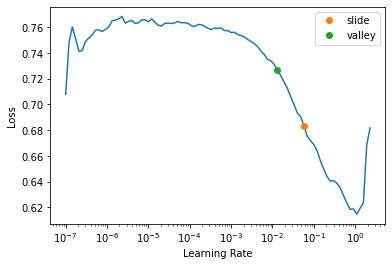

In [ ]:
learn.lr_find(suggest_funcs=(slide, valley))

The two colored points are both reasonable choices for a learning rate. I'll pick somewhere between the two (0.03) and train for a few epochs:

In [ ]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.577146,0.582949,0.606742,00:00
1,0.510818,0.498523,0.786517,00:00
2,0.467023,0.459841,0.797753,00:00
3,0.439957,0.468547,0.797753,00:00
4,0.427232,0.415261,0.825843,00:00
5,0.416340,0.437362,0.820225,00:00
6,0.408347,0.413253,0.848315,00:00
7,0.400442,0.406075,0.803371,00:00
8,0.397265,0.443730,0.820225,00:00
9,0.392389,0.432267,0.831461,00:00


We've got a similar accuracy to our previous "from scratch" model -- which isn't too surprising, since as we discussed, this dataset is too small and simple to really see much difference. A simple linear model already does a pretty good job. But that's OK -- the goal here is to show you how to get started with deep learning and understand how it really works, and the best way to do that is on small and easy to understand datasets.

## Submit to Kaggle

One important feature of fastai is that all the information needed to apply the data transformations and the model to a new dataset are stored in the learner. You can call `export` to save it to a file to use it later in production, or you can use the trained model right away to get predictions on a test set.

To submit to Kaggle, we'll need to read in the test set, and do the same feature engineering we did for the training set:

In [ ]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

But we don't need to manually specify any of the processing steps necessary to get the data ready for modeling, since that's all saved in the learner. To specify we want to apply the same steps to a new dataset, use the `test_dl()` method:

In [ ]:
tst_dl = learn.dls.test_dl(tst_df)

Now we can use `get_preds` to get the predictions for the test set:

In [ ]:
preds, _ = learn.get_preds(dl=tst_dl)

In [ ]:
preds[:10,:]

tensor([[0.8755, 0.1245],
        [0.8073, 0.1927],
        [0.9635, 0.0365],
        [0.9113, 0.0887],
        [0.3139, 0.6861],
        [0.9187, 0.0813],
        [0.4093, 0.5907],
        [0.8943, 0.1057],
        [0.1984, 0.8016],
        [0.9028, 0.0972]])

In [ ]:
preds.shape

torch.Size([418, 2])

Finally, let's create a submission CSV just like we did in the previous notebook...

In [ ]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('titanic/sub2.csv', index=False)

...and check that it looks reasonable:

In [ ]:
!head titanic/sub2.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


In [ ]:
import kaggle
kaggle.api.competition_submit_cli('titanic/sub2.csv', 'fastai lesson 5 feature engineering', competition=path.name)

100%|██████████| 2.77k/2.77k [00:00<00:00, 4.63kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster

## Ensembling

Since it's so easy to create a model now, it's easier to play with more advanced modeling approaches. For instance, we can create five separate models, each trained from different random starting points, and average them. This is the simplest approach of [ensembling](https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/) models, which combines multiple models to generate predictions that are better than any of the single models in the ensemble.

To create our ensemble, first we copy the three steps we used above to create and train a model, and apply it to the test set:

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10, 10])
    with learn.no_bar(), learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

Now we run this five times, and collect the results into a list:

In [ ]:
multiple_preds = [ensemble() for _ in range(5)]

We stack this predictions together and take their average predictions:

In [ ]:
ens_preds = torch.stack(multiple_preds).mean(0)

Finally, use the same code as before to generate a submission file, which we can submit to Kaggle after the notebook is saved and run:

In [ ]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('titanic/sub3.csv', index=False)

In [ ]:
kaggle.api.competition_submit_cli('titanic/sub3.csv', 'fastai lesson 5 ensemble', competition=path.name)

100%|██████████| 2.77k/2.77k [00:00<00:00, 3.41kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster

At the time of writing, this submission is well within the top 25% of entries to the competition.

(A lot of submissions to this competition use additional external data, but we have restricted ourselves to just using the data provided. We'd probably do a lot better if we used external data too. Feel free to give that a try, and see how you go. Note that you'll never be able to get to the top of the leaderboard, since a lot of folks in this competition have cheated, by downloading the answers from the internet and uploading them as their submission. In a real competition that's not possible, because the answers aren't public, but there's nothing stopping people from cheating in a tutorial/practice competition like this one. So if you're ready for a real challenge, take a look at the [competitions page](https://www.kaggle.com/competitions/) and start working on a real competition!)

## Final thoughts

As you can see, using fastai and PyTorch made things much easier than doing it from scratch, but it also hid away a lot of the details. So if you only ever use a framework, you're not going to as fully understand what's going on under the hood. That understanding can be really helpful when it comes to debugging and improving your models. But do use fastai when you're creating models on Kaggle or in "real life", because otherwise you're not taking advantage of all the research that's gone into optimising the models for you, and you'll end up spending more time debugging and implementing menial boiler-plate than actually solving the real problem!

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. (BTW, be sure you're looking at my [original notebook](https://www.kaggle.com/jhoward/why-you-should-use-a-framework) here when you do that, and are not on your own copy of it, otherwise your upvote won't get counted!) And if you have any questions or comments, please pop them below -- I read every comment I receive!